In [1]:
import tensorflow as tf
# import tensorflow_text as text # https://github.com/tensorflow/text/issues/192
import numpy as np
import pandas as pd

import os

from IPython import display

In [2]:
path = "rt-polaritydata/rt-polaritydata/"

pos_path = os.path.join(path, 'rt-polarity.pos')
neg_path = os.path.join(path, 'rt-polarity.neg')
print(pos_path, neg_path)

rt-polaritydata/rt-polaritydata/rt-polarity.pos rt-polaritydata/rt-polaritydata/rt-polarity.neg


In [3]:
def load_review(path, is_pos=True):
    with open(path, 'r', encoding='latin-1') as f:
        review = pd.DataFrame({'review':f.read().splitlines()})
    review['sentiment'] = 1 if is_pos else 0
    return review

In [4]:
pos_review = load_review(pos_path, is_pos=True)
neg_review = load_review(neg_path, is_pos=False)

all_reviews = pd.concat([pos_review, neg_review])
all_reviews.head()

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [5]:
all_reviews.review_split = all_reviews.review.map(lambda line: line.split())

C:\Users\studia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


### LSTM model

In [6]:
import operator
from functools import reduce

def create_vocabulary(df):
    splitted_reviews = df.review.map(lambda line: line.split())
    vocab = set(reduce(operator.add, splitted_reviews))
    return list(vocab)

vocab = create_vocabulary(all_reviews)

VOCAB_SIZE = len(vocab)
print('Total vocabluary size: {} words'.format(VOCAB_SIZE))

Total vocabluary size: 21401 words


In [7]:
word_to_number = {vocab[i]: i for i in range(VOCAB_SIZE)}
number_to_word = {i:vocab[i] for i in range(VOCAB_SIZE)}

In [8]:
df = all_reviews.copy()
df["review_splitted"] = df.review.map(lambda line: line.split())
df.head()

,review,sentiment,review_splitted
0,the rock is destined to be the 21st century's ...,1,"[the, rock, is, destined, to, be, the, 21st, c..."
1,"the gorgeously elaborate continuation of "" the...",1,"[the, gorgeously, elaborate, continuation, of,..."
2,effective but too-tepid biopic,1,"[effective, but, too-tepid, biopic]"
3,if you sometimes like to go to the movies to h...,1,"[if, you, sometimes, like, to, go, to, the, mo..."
4,"emerges as something rare , an issue movie tha...",1,"[emerges, as, something, rare, ,, an, issue, m..."


In [9]:
df["review_enc"] = df.review_splitted.map(lambda line: \
                                          [word_to_number[word] for word in line])

In [23]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset_tf, test_dataset = dataset['train'], dataset['test']

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [18]:
from sklearn.model_selection import train_test_split

X = df.review_splitted.values.tolist()
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), y_train.shape, len(X_test), y_test.shape

(8556, (8556,), 2139, (2139,))

In [19]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token='<UNK>')
tokenizer.fit_on_texts(df.review_splitted)


#convert text data to numerical indexes
rain_seqs=tokenizer.texts_to_sequences(X_train)
test_seqs=tokenizer.texts_to_sequences(X_test)

In [20]:
SEQ_LEN = max([len(x) for x in X_test]) + 5

train_seqs = tf.keras.preprocessing.sequence.pad_sequences(rain_seqs, maxlen=SEQ_LEN, padding="post")
test_seqs = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=SEQ_LEN, padding="post")

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [42]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          1369664   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,542,849
Trainable params: 1,542,849
Non-trainable params: 0
_________________________________________________________________


In [44]:
BATCH_SIZE = 64

history = model.fit(train_seqs, 
                    y_train.values,
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    validation_data=(test_seqs, y_test.values))

Train on 8556 samples, validate on 2139 samples
Epoch 1/10
8556/8556 [==============================] - 13s 1ms/sample - loss: 0.6930 - accuracy: 0.5127 - val_loss: 0.6921 - val_accuracy: 0.5171
Epoch 2/10
8556/8556 [==============================] - 6s 652us/sample - loss: 0.6585 - accuracy: 0.6355 - val_loss: 0.6134 - val_accuracy: 0.6400
Epoch 3/10
8556/8556 [==============================] - 6s 653us/sample - loss: 0.4336 - accuracy: 0.8019 - val_loss: 0.5598 - val_accuracy: 0.7256
Epoch 4/10
8556/8556 [==============================] - 6s 655us/sample - loss: 0.2762 - accuracy: 0.8873 - val_loss: 0.5685 - val_accuracy: 0.7401
Epoch 5/10
8556/8556 [==============================] - 6s 652us/sample - loss: 0.1774 - accuracy: 0.9351 - val_loss: 0.6378 - val_accuracy: 0.7401
Epoch 6/10
8556/8556 [==============================] - 6s 655us/sample - loss: 0.1167 - accuracy: 0.9605 - val_loss: 0.7578 - val_accuracy: 0.7433
Epoch 7/10
8556/8556 [==============================] - 6s 657us/

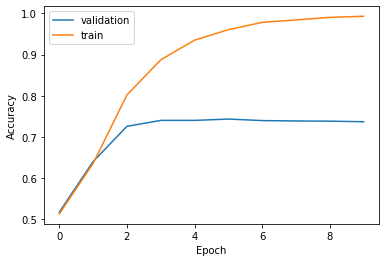

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], label = 'validation')
plt.plot(history.history['accuracy'], label = 'train')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [49]:
sample_pred_text = 'the movie was cool . the animation and the graphics were amazing'

encoded_sample_pred_text = [word_to_number[w] for w in sample_pred_text.split()]
encoded_sample_pred_text

[14457, 11548, 12513, 19219, 978, 14457, 11610, 3605, 14457, 5750, 6219, 6090]

In [50]:
model.predict([encoded_sample_pred_text])

array([[0.7030581]], dtype=float32)